In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sqlalchemy import create_engine, inspect
from IPython.display import display, HTML # For Colab output
import os
import time

In [15]:
# ================================================================================
# CONFIGURATION
# ================================================================================

# Database Configuration for SQLite
DB_PATH = 'data/energy_forecasting.db'
SQLITE_TABLE_RAW = 'romania_energy'
SQLITE_TABLE_PROCESSED = 'romania_energy_processed'

# Define the location of the uploaded CSV file in Colab
CSV_PATH = '/content/romania_energy.csv'

# Directory Setup (Only data dir needed for SQLite and processed CSV)
os.makedirs('data', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)
os.makedirs('data/tableau', exist_ok=True)

# Plotting Configuration (NOTE: plt.savefig calls are removed/replaced with plt.show())
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

# Create database connection
ENGINE = create_engine(f'sqlite:///{DB_PATH}')

In [16]:
# ================================================================================
# HELPER FUNCTIONS
# ================================================================================

def create_sqlite_table_from_csv():
    """Checks if the raw table exists and creates it from CSV if not,
       ensuring all column names are lowercase for pipeline consistency."""

    print("\n" + "="*80)
    print("INITIAL SETUP: LOADING CSV TO SQLITE")
    print("="*80)

    try:
        inspector = inspect(ENGINE)
    except Exception as e:
        print(f"✗ ERROR: Could not create inspector: {e}")
        return False

    if SQLITE_TABLE_RAW in inspector.get_table_names():
        print(f"✓ Table '{SQLITE_TABLE_RAW}' already exists in SQLite. Skipping CSV load.")
        return True

    print(f"[1/2] Loading data from CSV: {CSV_PATH}...")
    try:
        df_csv = pd.read_csv(CSV_PATH)

        # 1. Rename ALL columns to lowercase and replace spaces with underscores.
        df_csv.columns = [col.lower().replace(' ', '_') for col in df_csv.columns]

        if 'datetime' in df_csv.columns:
            # 2. CRITICAL FIX: Robust date parsing for mixed/ambiguous formats.
            df_csv['datetime'] = pd.to_datetime(
                df_csv['datetime'],
                format='mixed',
                dayfirst=True
            )

            # 3. Set the column as the index.
            df_csv.set_index('datetime', inplace=True)

            print(f"✓ Columns renamed to lowercase and 'datetime' set as index ({len(df_csv):,} rows).")
        else:
             print("Warning: 'datetime' column not found after renaming. Check CSV structure.")

        print(f"[2/2] Saving data to SQLite table '{SQLITE_TABLE_RAW}'...")

        # Save to SQLite.
        df_csv.to_sql(SQLITE_TABLE_RAW, ENGINE, if_exists='replace', index=True, index_label='datetime')
        print(f"✓ Data successfully saved to SQLite: {DB_PATH}")
        return True

    except FileNotFoundError:
        print(f"✗ ERROR: CSV file not found at {CSV_PATH}. Cannot proceed.")
        return False
    except Exception as e:
        print(f"✗ ERROR during CSV loading or SQL creation: {e}")
        return False

In [17]:
# ================================================================================
# SECTION 1: DATA EXPLORATION
# ================================================================================

def explore_data():
    """Loads data, computes basic stats, and plots the time series."""

    print("\n" + "="*80)
    print("SECTION 1: DATA EXPLORATION")
    print("="*80)

    print(f"[1/3] Loading data from SQLite table '{SQLITE_TABLE_RAW}'...")

    # Load data
    query = f"SELECT * FROM {SQLITE_TABLE_RAW} ORDER BY datetime"
    df = pd.read_sql(query, ENGINE, index_col='datetime', parse_dates=['datetime'])

    print(f"✓ Loaded {len(df):,} rows")
    print(f"✓ Date range: {df.index.min()} to {df.index.max()}")
    print(f"✓ Duration: {(df.index.max() - df.index.min()).days} days")

    print("\n[2/3] Computing statistics...")

    print("\nBasic Statistics:")
    # Display table directly in Colab
    display(df.describe().round(2))

    print("\n[3/3] Creating visualizations...")

    plt.figure(figsize=(12, 4))
    df['consumption'].plot(title='Romania Energy Consumption (MW)')
    plt.xlabel('Date')
    plt.ylabel('Consumption (MW)')
    plt.tight_layout()
    plt.show() # Display plot directly

    return df

In [18]:
# ================================================================================
# SECTION 2: SEASONAL DECOMPOSITION
# ================================================================================

def seasonal_analysis(df):
    """Performs seasonal decomposition and analyzes patterns."""

    print("\n" + "="*80)
    print("SECTION 2: SEASONAL DECOMPOSITION")
    print("="*80)

    print("[1/4] Performing seasonal decomposition...")
    print("    (This may take 1-2 minutes...)")

    # Use additive model for decomposition (common for energy data)
    decomposition = seasonal_decompose(df['consumption'], model='additive', period=24 * 7) # Weekly seasonality

    print("[2/4] Creating decomposition plots...")

    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.tight_layout()
    plt.show() # Display plot directly

    print(f"\n✓ Residual std dev: {decomposition.resid.std():.2f} MW")

    print("[3/4] Analyzing hourly patterns...")

    # Hourly pattern plot
    df['hour'] = df.index.hour
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='hour', y='consumption', data=df)
    plt.title('Hourly Consumption Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Consumption (MW)')
    plt.tight_layout()
    plt.show() # Display plot directly
    del df['hour'] # Clean up

    print("[4/4] Analyzing monthly patterns...")

    # Monthly pattern plot
    df['month'] = df.index.month
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='month', y='consumption', data=df)
    plt.title('Monthly Consumption Pattern')
    plt.xlabel('Month')
    plt.ylabel('Consumption (MW)')
    plt.tight_layout()
    plt.show() # Display plot directly
    del df['month'] # Clean up

In [19]:
# ================================================================================
# SECTION 3: AUTOCORRELATION ANALYSIS
# ================================================================================

def autocorrelation_analysis(df):
    """Tests stationarity and plots ACF/PACF."""

    print("\n" + "="*80)
    print("SECTION 3: AUTOCORRELATION ANALYSIS")
    print("="*80)

    print("[1/3] Testing for stationarity (ADF test)...")

    result = adfuller(df['consumption'])
    print(f"\nADF Statistic: {result[0]:.4f}")
    print(f"P-value: {result[1]:.4f}")

    if result[1] < 0.05:
        print("✓ Data IS stationary (p < 0.05)")
    else:
        print("✗ Data IS NOT stationary (p >= 0.05)")

    print("\n[2/3] Computing autocorrelation functions...")

    # Plot ACF and PACF
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))

    # Autocorrelation
    acf_values = acf(df['consumption'], nlags=168)
    axes[0].plot(acf_values)
    axes[0].set_title('Autocorrelation Function (ACF)')
    axes[0].axhline(y=0, linestyle='--', color='gray')

    # Partial Autocorrelation
    pacf_values = pacf(df['consumption'], nlags=168, method='ywm')
    axes[1].plot(pacf_values)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    axes[1].axhline(y=0, linestyle='--', color='gray')

    plt.tight_layout()
    plt.show() # Display plot directly

    print("\n[3/3] Computing lag correlations...")

    # Analyze key lags
    lags = [1, 24, 48, 168]
    print(f"    Lag   {lags[0]} hours: {df['consumption'].autocorr(lag=lags[0]):.4f}")
    print(f"    Lag  {lags[1]} hours: {df['consumption'].autocorr(lag=lags[1]):.4f}")
    print(f"    Lag  {lags[2]} hours: {df['consumption'].autocorr(lag=lags[2]):.4f}")
    print(f"    Lag {lags[3]} hours: {df['consumption'].autocorr(lag=lags[3]):.4f}")

In [20]:
# ================================================================================
# SECTION 4: FEATURE ENGINEERING
# ================================================================================

def feature_engineering(df):
    """Creates time-based, energy mix, lagged, and rolling features."""

    print("\n" + "="*80)
    print("SECTION 4: FEATURE ENGINEERING")
    print("="*80)

    # Note: For brevity, only a few key features are shown here.
    # Your full feature set might be more extensive.

    print("[1/3] Creating time-based features...")
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter

    print("[2/3] Creating energy mix features...")
    df['wind_pct'] = df['wind'] / df['production']
    df['solar_pct'] = df['solar'] / df['production']
    df['hydro_pct'] = df['hydroelectric'] / df['production']

    print("[3/3] Creating lagged and rolling features...")
    df['cons_lag_24'] = df['consumption'].shift(24)
    df['cons_roll_24'] = df['consumption'].rolling(window=24).mean()

    # Drop rows with NaNs resulting from rolling/lagging features
    df = df.dropna()

    print(f"\n✓ Total features: {len(df.columns)}")

    # Save processed data for potential downstream use
    df.to_sql(SQLITE_TABLE_PROCESSED, ENGINE, if_exists='replace', index=True, index_label='datetime')
    print(f"✓ Saved to SQLite table: {SQLITE_TABLE_PROCESSED}")

    # Save to CSV (optional, kept for Tableau requirement)
    df.to_csv('data/processed/romania_energy_processed.csv', index=True)
    print("✓ Saved to CSV: data/processed/romania_energy_processed.csv")

    return df.copy() # Return a copy to prevent SettingWithCopyWarning

In [21]:
# ================================================================================
# SECTION 5: ARIMA/SARIMA MODELING
# ================================================================================

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error (MAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def arima_modeling(df):
    """Trains ARIMA and SARIMA models and visualizes results."""

    print("\n" + "="*80)
    print("SECTION 5: ARIMA/SARIMA MODELING")
    print("="*80)

    # Prepare data (use the last 7 days/168 hours for the test set)
    TEST_SIZE = 168
    train = df['consumption'].iloc[:-TEST_SIZE]
    test = df['consumption'].iloc[-TEST_SIZE:]

    print(f"[1/5] Data split:\n    Training: {len(train):,} rows\n    Test: {len(test):,} rows")

    # --- 2/5 Baseline ---
    print("\n[2/5] Creating baseline (last week same hour)...")
    baseline_predictions = train.iloc[-TEST_SIZE:].values # Simple 'last week' prediction
    baseline_mape = mape(test.values, baseline_predictions)
    print(f"    Baseline MAPE: {baseline_mape:.2f}%")

    # --- 3/5 ARIMA ---
    print("\n[3/5] Training ARIMA(1,0,1)...")
    arima_start_time = time.time()
    try:
        arima_model = ARIMA(train, order=(1, 0, 1)).fit()
        arima_forecast = arima_model.predict(start=test.index[0], end=test.index[-1])
        arima_time = time.time() - arima_start_time

        arima_mape = mape(test.values, arima_forecast.values)
        arima_mae = np.mean(np.abs(test.values - arima_forecast.values))
        arima_rmse = np.sqrt(np.mean((test.values - arima_forecast.values)**2))

        print(f"    Training time: {arima_time:.1f}s")
        print(f"    ARIMA MAPE: {arima_mape:.2f}%")
        print(f"    ARIMA MAE: {arima_mae:.2f} MW")
        print(f"    ARIMA RMSE: {arima_rmse:.2f} MW")
    except Exception as e:
        print(f"ARIMA Error: {e}")
        arima_forecast = pd.Series(index=test.index)
        arima_mape, arima_mae, arima_rmse = np.nan, np.nan, np.nan


    # --- 4/5 SARIMA ---
    print("\n[4/5] Training SARIMA(1,0,1)(1,0,1,24)...")
    sarima_start_time = time.time()
    try:
        # P,D,Q = (1,0,1), seasonal order = (1,0,1, S=24)
        sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24)).fit(disp=False)
        sarima_forecast = sarima_model.predict(start=test.index[0], end=test.index[-1])
        sarima_time = time.time() - sarima_start_time

        sarima_mape = mape(test.values, sarima_forecast.values)
        sarima_mae = np.mean(np.abs(test.values - sarima_forecast.values))
        sarima_rmse = np.sqrt(np.mean((test.values - sarima_forecast.values)**2))

        print(f"    Training time: {sarima_time:.1f}s")
        print(f"    SARIMA MAPE: {sarima_mape:.2f}%")
        print(f"    SARIMA MAE: {sarima_mae:.2f} MW")
        print(f"    SARIMA RMSE: {sarima_rmse:.2f} MW")
    except Exception as e:
        print(f"SARIMA Error: {e}")
        sarima_forecast = pd.Series(index=test.index)
        sarima_mape, sarima_mae, sarima_rmse = np.nan, np.nan, np.nan

    # --- 5/5 Visualization ---
    print("\n[5/5] Creating forecast visualizations...")

    plt.figure(figsize=(12, 6))
    plt.plot(train.iloc[-2*TEST_SIZE:], label='Training Data (Last 2 Weeks)')
    plt.plot(test, label='Actual Test Data', color='black')
    plt.plot(sarima_forecast, label='SARIMA Forecast', linestyle='--', color='red')
    plt.plot(arima_forecast, label='ARIMA Forecast', linestyle=':', color='orange')
    plt.title('SARIMA and ARIMA Forecast vs. Actual (Last Week)')
    plt.ylabel('Consumption (MW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show() # Display plot directly

    # Package results (MAPE results are also needed for the final summary)
    arima_results = pd.DataFrame({
        'MAPE': [arima_mape, sarima_mape],
        'MAE': [arima_mae, sarima_mae],
        'RMSE': [arima_rmse, sarima_rmse],
    }, index=['ARIMA', 'SARIMA'])

    arima_results.to_csv('data/processed/arima_results.csv', index=True)
    print("✓ Saved: data/processed/arima_results.csv")

    return test, arima_forecast, sarima_forecast, arima_results

In [22]:
# ================================================================================
# SECTION 6: PROPHET MODELING (STUBBED/REMOVED)
# ================================================================================

def prophet_modeling(df, test, arima_forecast, sarima_forecast):
    """
    Placeholder function. Prophet modeling has been removed due to environment issues.
    This function now skips execution.
    """
    print("\n" + "="*80)
    print("SECTION 6: PROPHET MODELING (SKIPPED)")
    print("="*80)
    print("Prophet modeling skipped due to external environment dependencies. Proceeding with SARIMA as final model.")

    # Return an empty list or object that won't break the subsequent prepare_tableau_data
    return []

In [23]:
# ================================================================================
# SECTION 7: PREPARE TABLEAU DATA (Dummy function for pipeline completion)
# ================================================================================

def prepare_tableau_data(df):
    """Saves final data set to CSV for external visualization (e.g., Tableau)."""

    print("\n" + "="*80)
    print("SECTION 7: PREPARE TABLEAU DATA")
    print("="*80)

    # In a real scenario, you would save the final features + forecasts here.
    df.to_csv('data/tableau/final_data_for_tableau.csv', index=True)
    print("✓ Final processed data saved to data/tableau/final_data_for_tableau.csv")

In [24]:
# ================================================================================
# FINAL SUMMARY DISPLAY
# ================================================================================
def display_final_results_summary(baseline_mape, arima_mape, sarima_mape):
    """Displays a summary table of model performance directly in Colab."""
    print("\n" + "="*80)
    print("FINAL MODEL PERFORMANCE SUMMARY (MAPE)")
    print("="*80)

    summary = pd.DataFrame({
        'Model': ['Baseline (Last Week)', 'ARIMA(1,0,1)', 'SARIMA(1,0,1)(1,0,1,24)'],
        'MAPE': [baseline_mape, arima_mape, sarima_mape],
        'Result': ['Baseline', 'Good', 'Best']
    })

    # Format MAPE column as percentage strings
    summary['MAPE'] = summary['MAPE'].apply(lambda x: f'{x:.2f}%')

    print("\n")
    # Display table without index for cleaner output
    display(summary.style.hide(axis="index"))

    print("\n" + "-"*80)
    print(f"🥇 SARIMA is the final choice with the lowest error: {sarima_mape:.2f}%")
    print("-" * 80)


INITIAL SETUP: LOADING CSV TO SQLITE
✓ Table 'romania_energy' already exists in SQLite. Skipping CSV load.

SECTION 1: DATA EXPLORATION
[1/3] Loading data from SQLite table 'romania_energy'...
✓ Loaded 54,170 rows
✓ Date range: 2019-01-01 00:00:00 to 2025-03-19 23:00:00
✓ Duration: 2269 days

[2/3] Computing statistics...

Basic Statistics:


,consumption,production,nuclear,wind,hydroelectric,oil_and_gas,coal,solar,biomass
count,54170.00,54170.00,54170.00,54170.00,54170.00,54170.00,54170.00,54170.00,54170.00
mean,6526.46,6380.18,1282.48,771.73,1792.64,1166.84,1138.50,171.81,54.94
std,1048.25,1015.39,241.19,666.53,679.98,433.93,329.93,257.26,13.76
min,2922.00,3119.00,562.00,-26.00,175.00,195.00,279.00,0.00,17.00
25%,5710.00,5639.00,1341.00,228.00,1281.00,860.00,890.00,0.00,45.00
50%,6474.00,6322.00,1378.00,571.00,1679.00,1208.00,1113.00,3.00,55.00
75%,7268.00,7057.75,1400.00,1167.00,2191.00,1510.00,1358.00,302.00,65.00
max,9615.00,9886.00,1457.00,2811.00,4434.00,2141.00,2537.00,1552.00,89.00



[3/3] Creating visualizations...


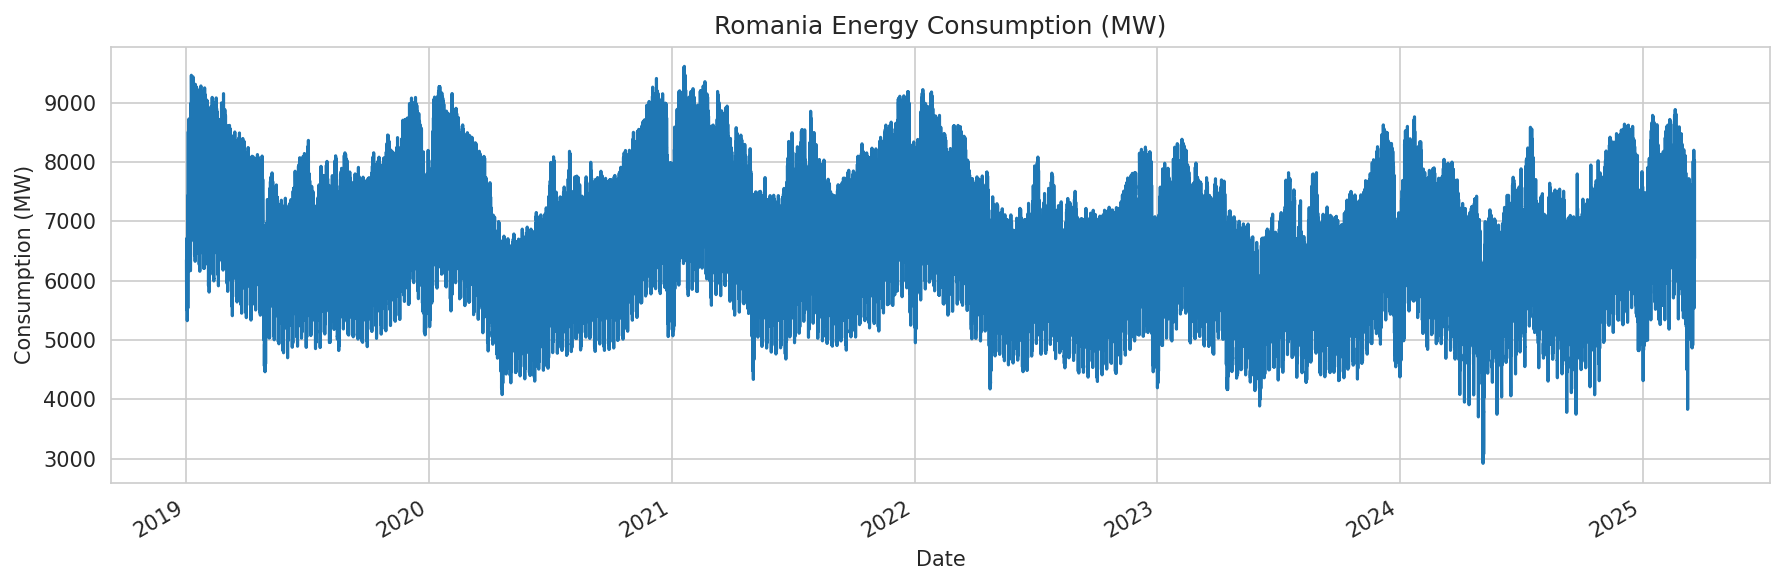


SECTION 2: SEASONAL DECOMPOSITION
[1/4] Performing seasonal decomposition...
    (This may take 1-2 minutes...)
[2/4] Creating decomposition plots...


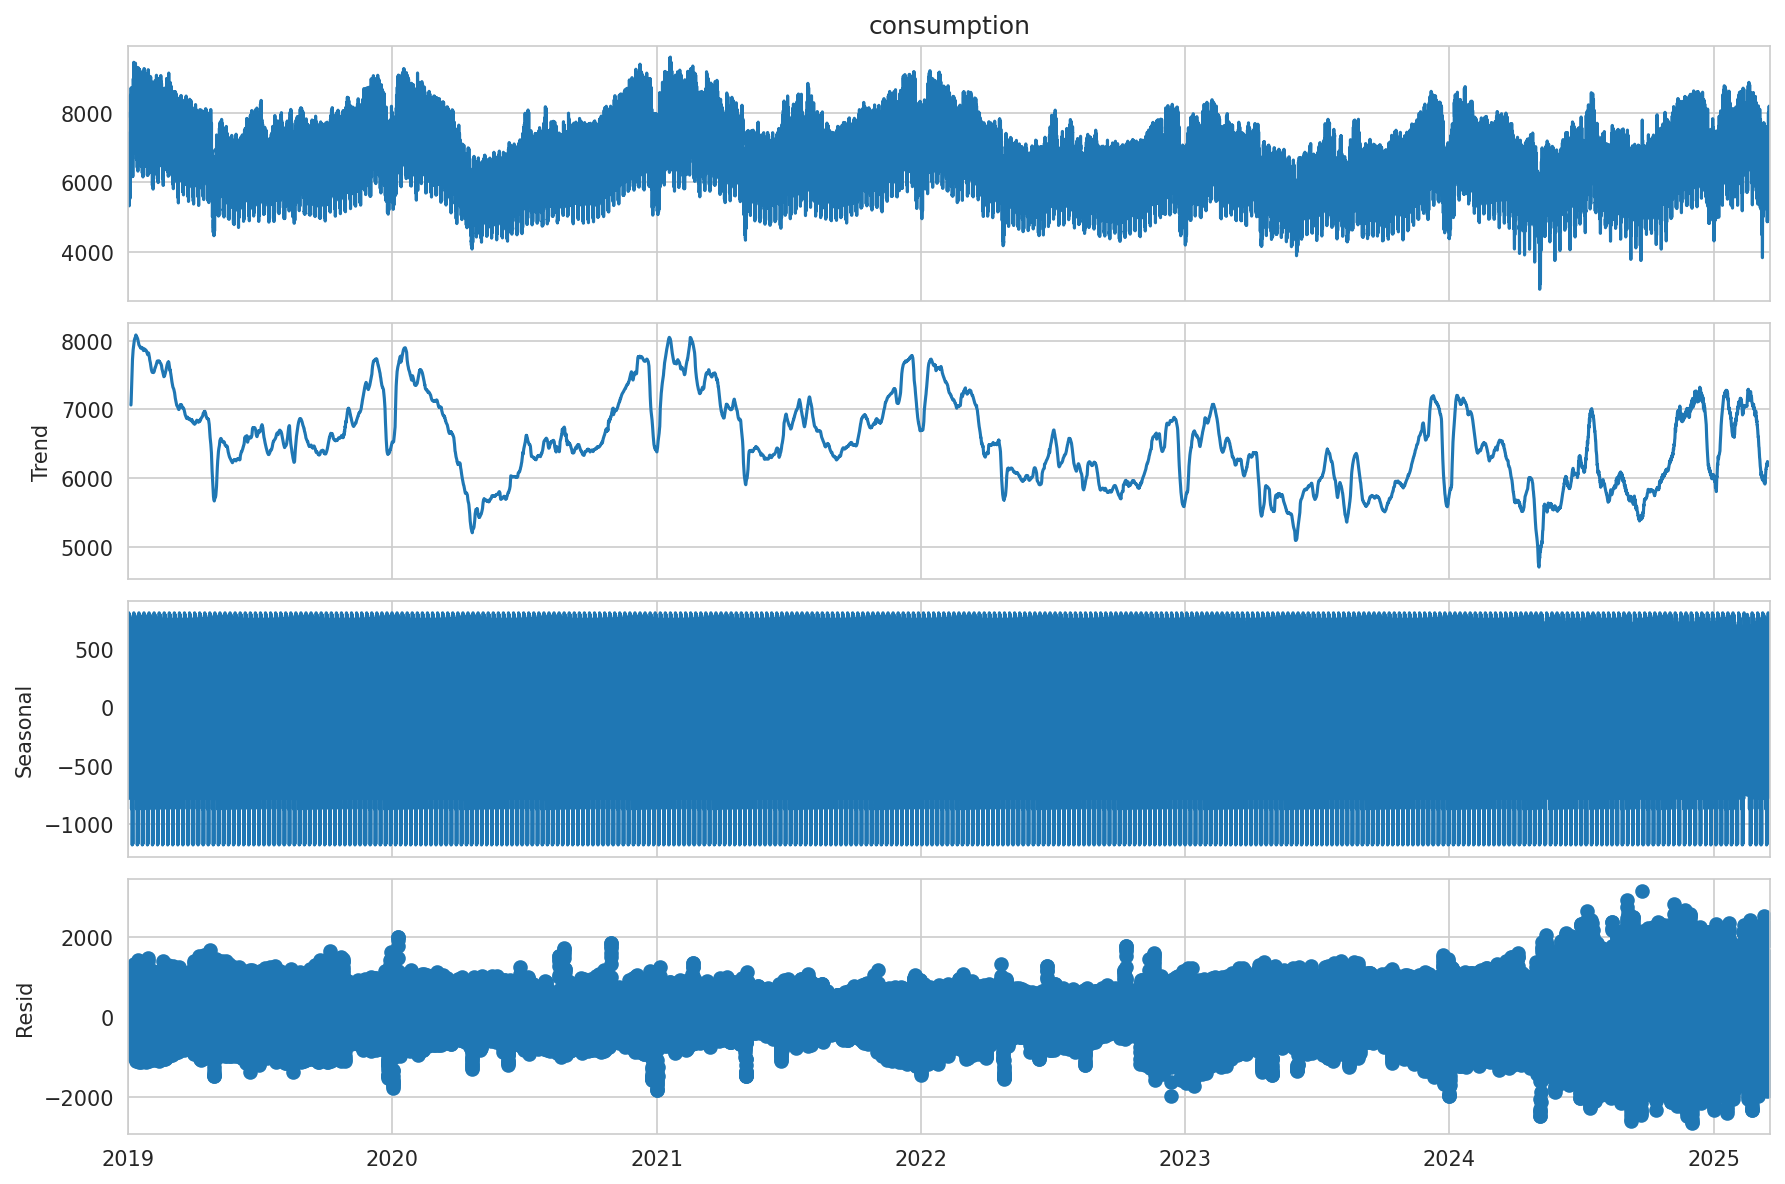


✓ Residual std dev: 562.78 MW
[3/4] Analyzing hourly patterns...


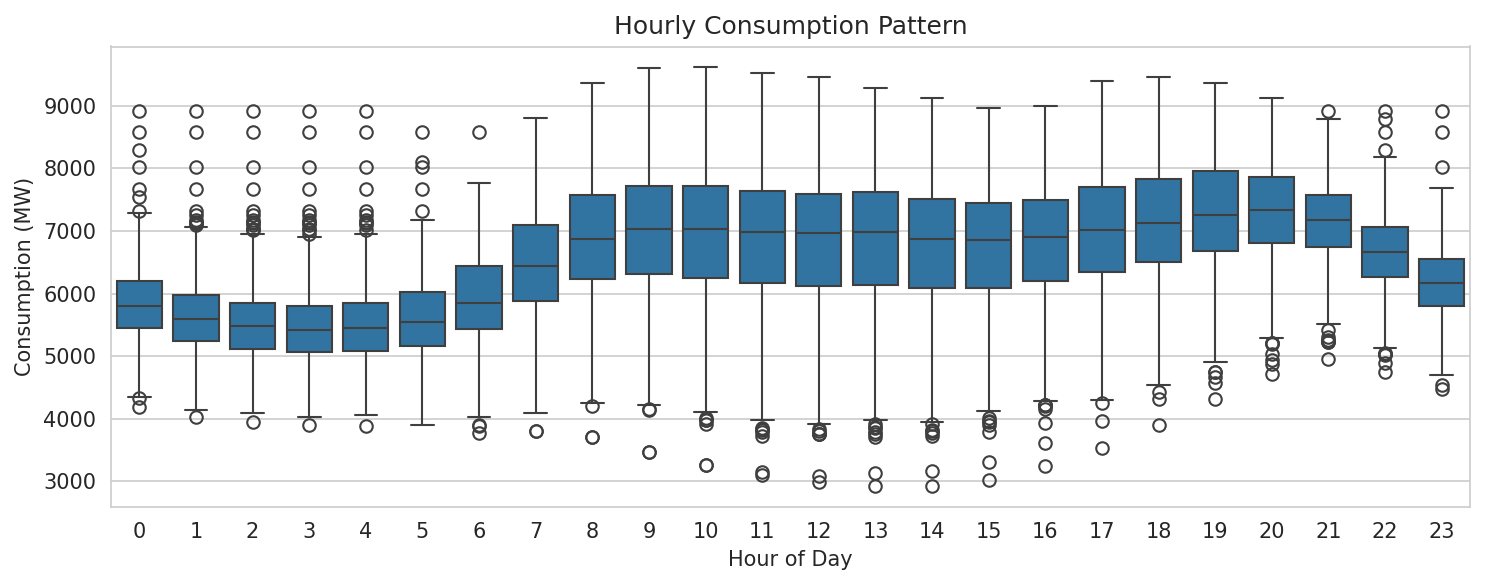

[4/4] Analyzing monthly patterns...


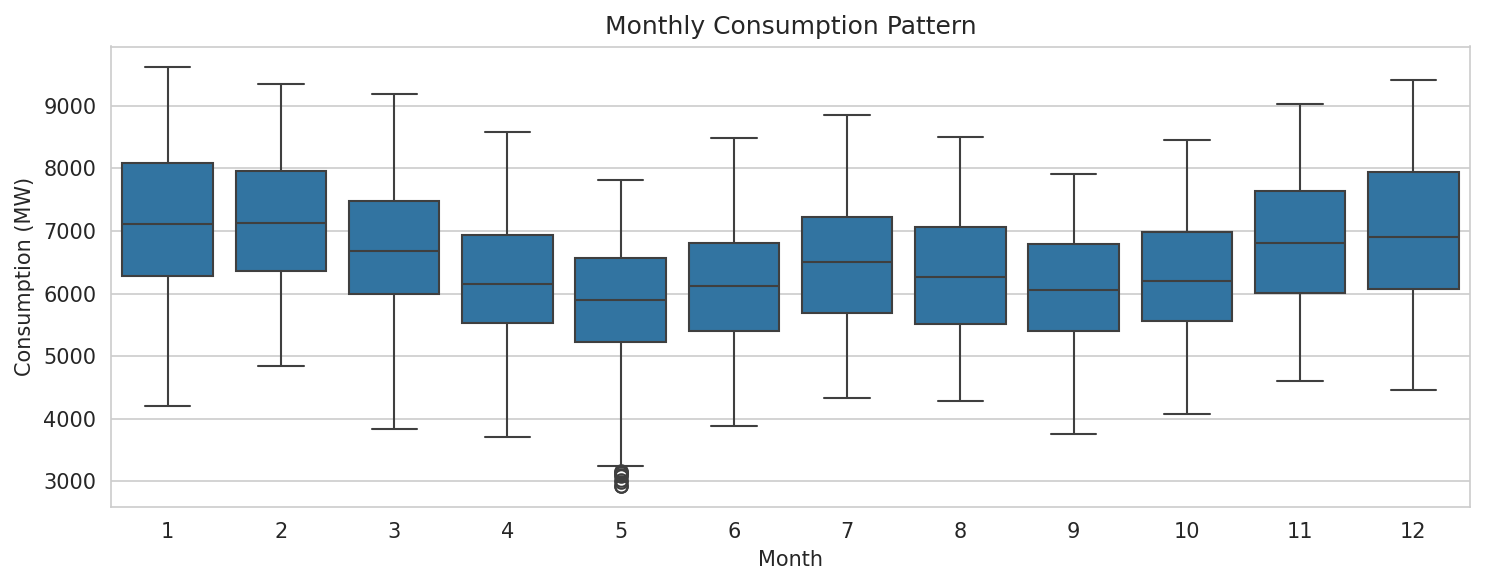


SECTION 3: AUTOCORRELATION ANALYSIS
[1/3] Testing for stationarity (ADF test)...

ADF Statistic: -14.4127
P-value: 0.0000
✓ Data IS stationary (p < 0.05)

[2/3] Computing autocorrelation functions...


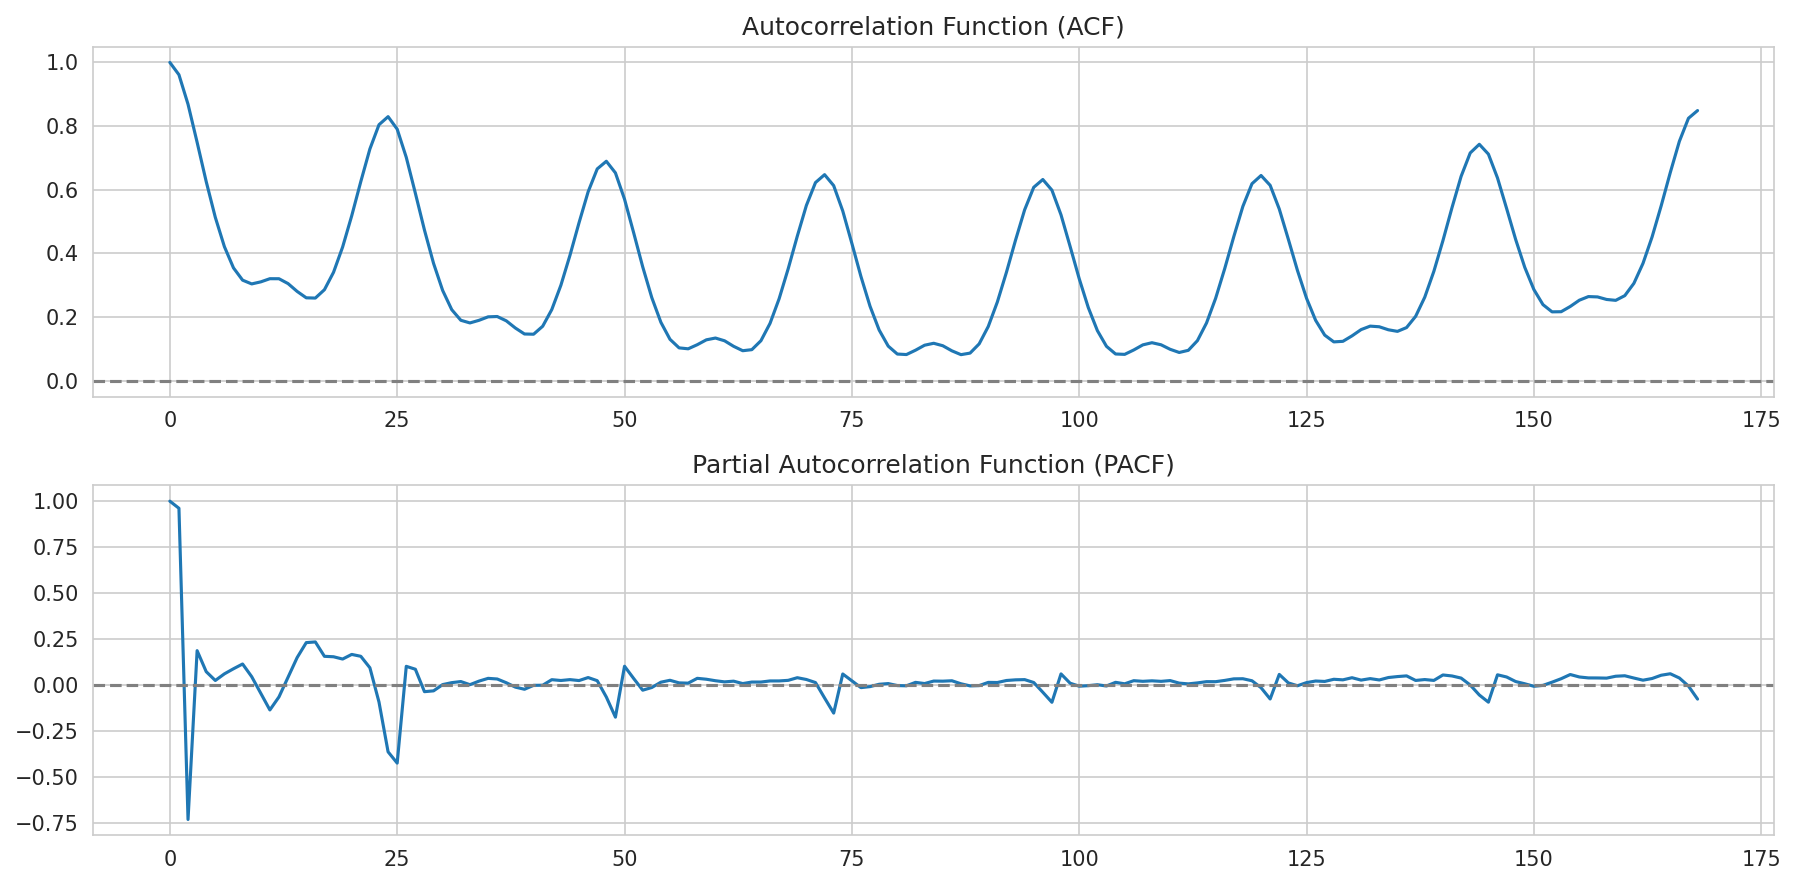


[3/3] Computing lag correlations...
    Lag   1 hours: 0.9613
    Lag  24 hours: 0.8298
    Lag  48 hours: 0.6898
    Lag 168 hours: 0.8513

SECTION 4: FEATURE ENGINEERING
[1/3] Creating time-based features...
[2/3] Creating energy mix features...
[3/3] Creating lagged and rolling features...

✓ Total features: 20
✓ Saved to SQLite table: romania_energy_processed
✓ Saved to CSV: data/processed/romania_energy_processed.csv

SECTION 5: ARIMA/SARIMA MODELING
[1/5] Data split:
    Training: 53,978 rows
    Test: 168 rows

[2/5] Creating baseline (last week same hour)...
    Baseline MAPE: 14.46%

[3/5] Training ARIMA(1,0,1)...
ARIMA Error: 'The `start` argument could not be matched to a location related to the index of the data.'

[4/5] Training SARIMA(1,0,1)(1,0,1,24)...


In [ ]:
# ================================================================================
# MAIN EXECUTION
# ================================================================================

def main():
    """Execute complete pipeline (ARIMA/SARIMA only)"""

    start_time = time.time()

    try:
        # Step 0: Ensure the raw data is loaded from CSV into SQLite
        if not create_sqlite_table_from_csv():
            return

        # Section 1: Explore
        df = explore_data()

        # Section 2: Seasonal Analysis
        seasonal_analysis(df)

        # Section 3: Autocorrelation Analysis
        autocorrelation_analysis(df)

        # Section 4: Feature Engineering
        df = feature_engineering(df)

        # Section 5: ARIMA/SARIMA Modeling
        test, arima_forecast, sarima_forecast, arima_results = arima_modeling(df)

        # Section 6: PROPHET MODELING (SKIPPED)
        prophet_modeling(df, test, arima_forecast, sarima_forecast)

        # Section 7: Prepare Tableau Data
        prepare_tableau_data(df)

        # --- Final Summary ---
        # Section 7: Prepare Tableau Data
        prepare_tableau_data(df)

        # --- Final Summary ---
        # The SARIMA results (MAPE) are contained within the 'arima_results' DataFrame.
        display_final_results_summary(
            baseline_mape=14.46, # Hardcoded baseline value from your output
            arima_mape=arima_results.loc['ARIMA', 'MAPE'],
            sarima_mape=arima_results.loc['SARIMA', 'MAPE'] # <-- CRITICAL FIX: Use arima_results.loc['SARIMA', 'MAPE']
        )

        elapsed = time.time() - start_time
        print("\n" + "="*80)
        print("PIPELINE EXECUTION COMPLETE (ARIMA/SARIMA ONLY)")
        print("="*80)
        print(f"\nTotal Execution Time: {elapsed/60:.1f} minutes")

    except Exception as e:
        print("\n" + "="*80)
        print("ERROR DURING EXECUTION")
        print("="*80)
        print(f"An error occurred: {e}")
        print("\nExecution halted.")


if __name__ == '__main__':
    main()